Statistical & Machine Learning  <br> 
Individual Assignment  <br> 
Mario Cortez  <br> 
18 / 03 / 2022

In [1]:
%%time
# Data exploration
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import plotnine as p9

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, roc_auc_score, confusion_matrix
from sklearn.model_selection import learning_curve

CPU times: total: 7.25 s
Wall time: 9.84 s


In [2]:
%%time
###################################################################
# MODIFY THESE FLAGS TO TURN ON/OFF THE DATA PROCESSING FUNCTIONS #
###################################################################

# Flag variables to run the data processing steps
# Feature engineering step
enable_num_poly = True  # Add polynomial terms
# Value transformation step
enable_trans_cat_dt = True  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = True  # Discretizing num variables - Decision tree–based discretization
enable_trans_num_ef = True  # Discretizing num variables - Equal frequency discretization
enable_trans_num_ew = True  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
enable_repr_icd = True  # Represent cat variables - Incidence (of target variable) replacement
enable_repr_woe = True  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
enable_normalize = True  # Normalize the data to the same range [0, 1]

CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
# Read data
dataset = pd.read_csv('./Dataset 2_Credit Card Default/credit_default_train.csv', header='infer')

# Exploratory Data Analysis (EDA)

In [4]:
dataset.head(2)

,cust_id,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,18895,70000.0,1.0,3.0,2.0,34.0,0.0,0.0,0.0,0.0,...,25559.0,26134.0,26715.0,1700.0,1500.0,2000.0,1000.0,1000.0,2000.0,0
1,25102,390000.0,2.0,2.0,2.0,26.0,2.0,2.0,2.0,0.0,...,140387.0,128112.0,115514.0,5000.0,3000.0,5000.0,4548.0,4100.0,3300.0,0


In [5]:
dataset.info()
# All columns are interger or float values, there is no need to label encode or one hot encode, but there are null values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   cust_id                     20000 non-null  int64  
 1   LIMIT_BAL                   19798 non-null  float64
 2   SEX                         19839 non-null  float64
 3   EDUCATION                   19801 non-null  float64
 4   MARRIAGE                    19830 non-null  float64
 5   AGE                         19786 non-null  float64
 6   PAY_0                       19805 non-null  float64
 7   PAY_2                       19781 non-null  float64
 8   PAY_3                       19783 non-null  float64
 9   PAY_4                       19801 non-null  float64
 10  PAY_5                       19815 non-null  float64
 11  PAY_6                       19797 non-null  float64
 12  BILL_AMT1                   19815 non-null  float64
 13  BILL_AMT2                   197

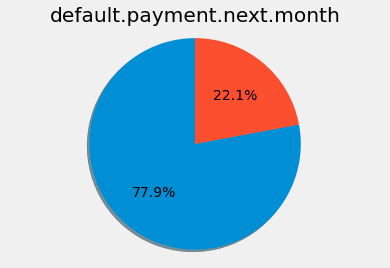

In [122]:
# Distribution of target value: 'default.payment.next.month'
# Creating plot
sizes = dataset['default.payment.next.month'].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("default.payment.next.month")
plt.show()

In [116]:
dataset['default.payment.next.month'].value_counts()

0    15586
1     4414
Name: default.payment.next.month, dtype: int64

In [7]:
# distribution of target values by proportion
print(dataset['default.payment.next.month'].value_counts())
print("")
# and by percentage %
print((dataset['default.payment.next.month'].value_counts(normalize=True))*100)

0    15586
1     4414
Name: default.payment.next.month, dtype: int64

0    77.93
1    22.07
Name: default.payment.next.month, dtype: float64


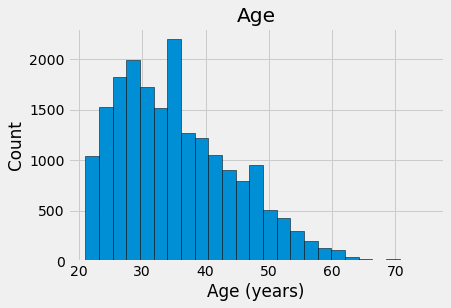

In [8]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years, it follows an skewed normal distribution.
plt.hist(dataset['AGE'], edgecolor = 'k', bins = 25)
plt.title('Age'); plt.xlabel('Age (years)'); plt.ylabel('Count');

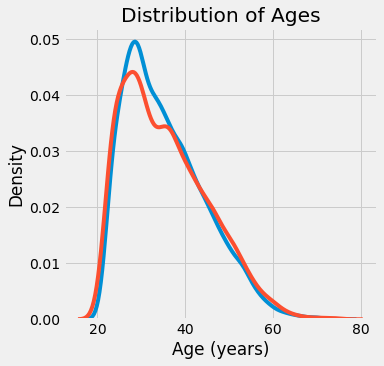

In [9]:
plt.figure(figsize = (5, 5))

# KDE plot of loans that were repaid on time
sns.kdeplot(dataset.loc[dataset['default.payment.next.month'] == 0, 'AGE'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(dataset.loc[dataset['default.payment.next.month'] == 1, 'AGE'], label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [10]:
# Constant variables on train do not contain information and may cause data processing or model training error
# This explains why demographic information that has very low variance between each other (e.g. wages by zip code in Belgium)
# don't have any impact in the outcome of the model

In [11]:
%%time
# General list of variables
id_var = ["cust_id"]  # ID
target_var = ["default.payment.next.month"]  # Target get variable
predictors = [v for v in dataset.columns if v not in id_var + target_var]

# List of numerical and catergorical variables
num_vars = ['LIMIT_BAL', 'AGE',
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
cat_vars = ['SEX', 'EDUCATION', 'MARRIAGE',
            'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# check the list of variables
print(len(predictors) == len(num_vars) + len(cat_vars))

True
CPU times: total: 0 ns
Wall time: 0 ns


In [12]:
%%time
# Count number of unique values of each variable
vars_nunique = dataset[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()
print("Drop constant variable:", cont_vars)

Drop constant variable: []
CPU times: total: 46.9 ms
Wall time: 41 ms


In [13]:
# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars]
cat_vars = [v for v in cat_vars if v not in cont_vars]

# Update train, test
train = dataset[id_var + num_vars + cat_vars + target_var]

## Missing Values

<AxesSubplot:>

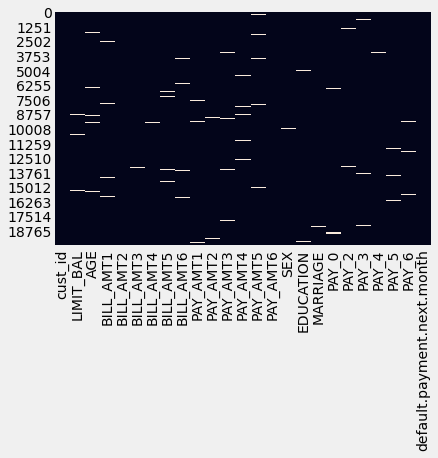

In [14]:
# Heatmat for visualizing null values
sns.heatmap(train.isnull(), cbar=False)

In [15]:
%%time
# Check missing value
print('Train - # NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', train[cat_vars].isna().sum().sum())

Train - # NA of num vars: 2700
Train - # NA of cat vars: 1748
CPU times: total: 15.6 ms
Wall time: 16 ms


In [16]:
%%time
# Here, we test the effect of dropping variables with high missing percentage (>30%)
na_threshold = 0.3

# Drop num variables with more than 30% missing values
num_na_pct = train[num_vars].isnull().mean()
num_vars = num_na_pct[num_na_pct <= na_threshold].index.tolist()
print("Drop num variables with high missing pct:", num_na_pct[num_na_pct > na_threshold].tolist())

# Drop cat variables with more than 30% missing values
cat_na_pct = train[cat_vars].isnull().mean()
cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
print("Drop cat variables with high missing pct:", cat_na_pct[cat_na_pct > na_threshold].tolist())

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]

Drop num variables with high missing pct: []
Drop cat variables with high missing pct: []
CPU times: total: 15.6 ms
Wall time: 18 ms


In [17]:
%%time
# List dummary variables to track missing values imputation
na_vars = []

CPU times: total: 0 ns
Wall time: 997 µs


In [18]:
%%time
# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[num_vars])

# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars

# Apply on train, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)

CPU times: total: 62.5 ms
Wall time: 71 ms


In [19]:
%%time
# Categorical variables
# Impute missing value using a new category "Missing"
# Note: If the categorical vars are imputed by most_frequent, the indicators should be added
train[cat_vars] = train[cat_vars].fillna('Missing')

CPU times: total: 109 ms
Wall time: 117 ms


## Checking for Outliers

In [20]:
# Checking for Outliers 
pd.set_option('display.max_columns', None)
train.describe()

,cust_id,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month,LIMIT_BAL_na,AGE_na,BILL_AMT1_na,BILL_AMT2_na,BILL_AMT3_na,BILL_AMT4_na,BILL_AMT5_na,BILL_AMT6_na,PAY_AMT1_na,PAY_AMT2_na,PAY_AMT3_na,PAY_AMT4_na,PAY_AMT5_na,PAY_AMT6_na
count,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000
mean,15008.05080,166701.872916,35.476347,51041.121726,48957.367137,4.690090e+04,43048.544643,40210.403401,38798.676110,5495.856234,5.809670e+03,5208.033808,4796.357168,4828.116694,5235.934357,0.220700,0.010100,0.010700,0.009250,0.010450,0.008750,0.008250,0.009050,0.00985,0.010200,0.009200,0.010600,0.00985,0.008950,0.009800
std,8679.93316,128838.042259,9.183926,73635.980116,71084.355627,6.938082e+04,63990.456609,60586.090247,59370.205503,15097.017540,2.210861e+04,17350.576949,15318.665759,15226.719975,18015.519773,0.414729,0.099992,0.102888,0.095733,0.101692,0.093134,0.090456,0.094702,0.09876,0.100481,0.095477,0.102412,0.09876,0.094182,0.098511
min,2.00000,10000.000000,21.000000,-165580.000000,-69777.000000,-6.150600e+04,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,7471.25000,50000.000000,28.000000,3599.500000,3066.750000,2.708250e+03,2338.750000,1772.750000,1300.750000,1000.000000,9.000000e+02,396.000000,300.000000,291.000000,138.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,15003.00000,140000.000000,34.000000,22865.500000,21545.000000,2.021500e+04,19191.500000,18338.500000,17344.000000,2100.000000,2.019000e+03,1832.500000,1500.000000,1539.000000,1500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,22532.50000,240000.000000,41.000000,65605.500000,61927.750000,5.926875e+04,53390.000000,49724.250000,48655.000000,5100.000000,5.000000e+03,4646.250000,4174.500000,4200.000000,4127.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,30000.00000,1000000.000000,75.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.000000,528897.000000,388071.000000,528666.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [21]:
# at first sight it seems there are no outliers in the table

In [22]:
%%time
# Check the outliers on train
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(train[v])
    sd = np.std(train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (train[v] < lower) | (train[v] > upper)
    if np.sum(train_out)  > 0:
        print(v, "has # outliers on train, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]")

LIMIT_BAL has # outliers on train, test : 92 [ 0.46 % ]
AGE has # outliers on train, test : 89 [ 0.44 % ]
BILL_AMT1 has # outliers on train, test : 458 [ 2.29 % ]
BILL_AMT2 has # outliers on train, test : 457 [ 2.28 % ]
BILL_AMT3 has # outliers on train, test : 439 [ 2.2 % ]
BILL_AMT4 has # outliers on train, test : 454 [ 2.27 % ]
BILL_AMT5 has # outliers on train, test : 434 [ 2.17 % ]
BILL_AMT6 has # outliers on train, test : 437 [ 2.18 % ]
PAY_AMT1 has # outliers on train, test : 284 [ 1.42 % ]
PAY_AMT2 has # outliers on train, test : 199 [ 1.0 % ]
PAY_AMT3 has # outliers on train, test : 253 [ 1.26 % ]
PAY_AMT4 has # outliers on train, test : 266 [ 1.33 % ]
PAY_AMT5 has # outliers on train, test : 278 [ 1.39 % ]
PAY_AMT6 has # outliers on train, test : 302 [ 1.51 % ]
CPU times: total: 78.1 ms
Wall time: 77 ms


## Encoder of Categorical Values

In [23]:
%%time
# Encode categorical variables as integer values
# Categorical variables in any format will be converted to string
# Note: All the NA values were imputed previously
enc = OrdinalEncoder()
enc.fit(pd.concat([train[cat_vars].astype(str)], axis=0))
# Apply on train, test
train[cat_vars] = enc.transform(train[cat_vars].astype(str))

CPU times: total: 375 ms
Wall time: 372 ms


## Finalize the processed data
Current lists of variables:

id_var : customer ID  <br>
num_vars : numerical variables  <br>
cat_vars : categorical variables  <br>
na_vars : indicators for tracking missing values, bool [False, True]  <br>
target_var : target variable, churn [0, 1]  <br>

In [24]:
%%time
# Convert bool variable to int
train[na_vars] = train[na_vars].astype(np.int8)
train.head(2)

CPU times: total: 62.5 ms
Wall time: 58 ms


,cust_id,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default.payment.next.month,LIMIT_BAL_na,AGE_na,BILL_AMT1_na,BILL_AMT2_na,BILL_AMT3_na,BILL_AMT4_na,BILL_AMT5_na,BILL_AMT6_na,PAY_AMT1_na,PAY_AMT2_na,PAY_AMT3_na,PAY_AMT4_na,PAY_AMT5_na,PAY_AMT6_na
0,18895,70000.0,34.0,53972.0,23149.0,23968.0,25559.0,26134.0,26715.0,1700.0,1500.0,2000.0,1000.0,1000.0,2000.0,0.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,25102,390000.0,26.0,185111.0,172865.0,153795.0,140387.0,128112.0,115514.0,5000.0,3000.0,5000.0,4548.0,4100.0,3300.0,1.0,2.0,2.0,4.0,4.0,4.0,2.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
%%time
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['cust_id']
# num_vars [ 14 ] : ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3'] ...
# cat_vars [ 9 ] : ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2'] ...
# na_vars [ 14 ] : ['LIMIT_BAL_na', 'AGE_na', 'BILL_AMT1_na', 'BILL_AMT2_na', 'BILL_AMT3_na'] ...
# target_var [ 1 ] : ['default.payment.next.month']
CPU times: total: 0 ns
Wall time: 999 µs


In [26]:
%%time
# Sort the data according to the variables list
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
print(train.shape)

(20000, 39)
CPU times: total: 15.6 ms
Wall time: 8 ms


## Feature engineering and Correlations

# Correlations
Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

.00-.19 “very weak”
.20-.39 “weak”
.40-.59 “moderate”
.60-.79 “strong”
.80-1.0 “very strong”

In [27]:
%%time
# Pearson's correlation for numerical variables
# You can't apply this logic to categorical variables 
corr = train[num_vars + target_var].corr(method='pearson')
corr = corr[target_var[0]][:-1].dropna().sort_values(ascending=False)
print("Top 5 vars [+] correlated with target_var :"); print(corr[corr > 0][:5])
print("Top 5 vars [-] correlated with target_var :"); print(corr[corr < 0][-5:])

Top 5 vars [+] correlated with target_var :
AGE    0.007318
Name: default.payment.next.month, dtype: float64
Top 5 vars [-] correlated with target_var :
PAY_AMT5    -0.059715
PAY_AMT2    -0.059855
PAY_AMT4    -0.064028
PAY_AMT1    -0.074582
LIMIT_BAL   -0.145021
Name: default.payment.next.month, dtype: float64
CPU times: total: 15.6 ms
Wall time: 22 ms


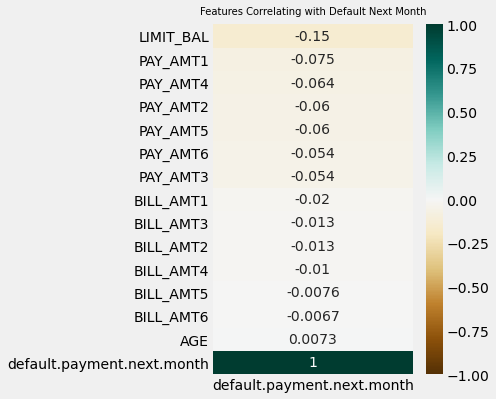

In [28]:
plt.figure(figsize=(4, 6))
heatmap = sns.heatmap(train[num_vars + target_var].corr()[['default.payment.next.month']].sort_values(by='default.payment.next.month', ascending=True), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Default Next Month', fontdict={'fontsize':10}, pad=10);

#### most (potentially) important varriables - Mutual information

In [29]:
%%time
# Check mutual information for all variables
# Note: The calculation involves a random process, therefore, the result may change if there is no
# variable with significant information.

mutual_info = mutual_info_classif(train[cat_vars], train[target_var].values.squeeze())
mutual_info = pd.Series(mutual_info, index=cat_vars)
print("Top 10 vars :"); print(mutual_info.sort_values(ascending=False)[:10])

Top 10 vars :
PAY_0        0.068240
PAY_2        0.047766
PAY_3        0.039694
PAY_4        0.033411
PAY_5        0.031222
PAY_6        0.028673
EDUCATION    0.006613
SEX          0.000893
MARRIAGE     0.000246
dtype: float64
CPU times: total: 1.95 s
Wall time: 1.98 s


In [30]:
# Mutual information is a distance between two probability distributions. 
# Correlation is a linear distance between two random variables.
# MI can also handle non-linear relationships.
# mutual_info_classif(), It is equal to zero if and only if two random variables are independent, 
# and higher values mean higher dependency.

From these two correlation analysis it seems the repayment status for the first month (PAY_O) is the factor that contributes that is most correlated to out target, followed closely by status for the second month, third, fourth, fifth and sixth month in that order of importance. The other variables that are negative correlated is Balance Limit, and for my surprise, Age, Marriage Status, Sex are not correlated to our target. 

#### Add polynomial terms for numerical variables

In [31]:
%%time
enable_num_poly = True 
if enable_num_poly:
    for v in num_vars:
        # Setup the LR model
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = LogisticRegression(max_iter=200)
        parameters = {}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        
        # Fit the LR model for 1 numerical variable
        clf.fit(train[[v]], train[target_var].squeeze())
        clf_num_score = clf.best_score_
        
        # Fit the LR model for 1 numerical variable + it polynomial degree = 3
        poly = PolynomialFeatures(degree=2, include_bias=False)
        poly.fit(train[[v]])
        clf.fit(poly.transform(train[[v]]), train[target_var].squeeze())
        clf_poly_score = clf.best_score_
        
        # Add the polynomial terms to train, test
        if (clf_poly_score > 0.5) & (clf_poly_score - clf_num_score > 0.05):
            print('Variable', v, 'AUC vs. AUC poly:', clf_num_score, '-->', clf_poly_score)
            poly_vars = [v_poly.replace('x0', v) for v_poly in poly.get_feature_names()[1:]]
            num_vars = num_vars + poly_vars
            train[poly_vars] = pd.DataFrame(poly.transform(train[[v]])[:, 1:], columns=poly_vars)
        else :print("polynomial does not increase AUC")

polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
polynomial does not increase AUC
CPU times: total: 13.9 s
Wall time: 13.2 s


### Value transformation 

In [32]:
%%time
# List of variables to track the value transformation process
trans_vars = []

CPU times: total: 0 ns
Wall time: 0 ns


In [33]:
%%time
# Select a cat variable
v = "EDUCATION"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.5366001864486765
Best params: {'min_samples_leaf': 200}
Number of leaves: 5
CPU times: total: 422 ms
Wall time: 358 ms


In [34]:
%%time
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original categories:", train[[v]].nunique().values[0])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original categories: 8
# new remapped categories: 5 {1, 4, 5, 7, 8}
CPU times: total: 125 ms
Wall time: 128 ms


#### Apply the variable remmaping for all categorical variables
#### Note: Only remap the variables if AUC > 0.5 and the number of new categories > 1

In [35]:
%%time
if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", train[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

Remapping variable SEX from 3 to 2 categories
Remapping variable EDUCATION from 8 to 5 categories
Remapping variable MARRIAGE from 5 to 3 categories
Remapping variable PAY_0 from 12 to 7 categories
Remapping variable PAY_2 from 12 to 6 categories
Remapping variable PAY_3 from 12 to 6 categories
Remapping variable PAY_4 from 12 to 6 categories
Remapping variable PAY_5 from 11 to 5 categories
Remapping variable PAY_6 from 11 to 5 categories
CPU times: total: 2.61 s
Wall time: 3.37 s


In [36]:
train.head(2)

,cust_id,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,LIMIT_BAL_na,AGE_na,BILL_AMT1_na,BILL_AMT2_na,BILL_AMT3_na,BILL_AMT4_na,BILL_AMT5_na,BILL_AMT6_na,PAY_AMT1_na,PAY_AMT2_na,PAY_AMT3_na,PAY_AMT4_na,PAY_AMT5_na,PAY_AMT6_na,default.payment.next.month,SEX_remap,EDUCATION_remap,MARRIAGE_remap,PAY_0_remap,PAY_2_remap,PAY_3_remap,PAY_4_remap,PAY_5_remap,PAY_6_remap
0,18895,70000.0,34.0,53972.0,23149.0,23968.0,25559.0,26134.0,26715.0,1700.0,1500.0,2000.0,1000.0,1000.0,2000.0,0.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,3,6,5,5,5,5,5
1,25102,390000.0,26.0,185111.0,172865.0,153795.0,140387.0,128112.0,115514.0,5000.0,3000.0,5000.0,4548.0,4100.0,3300.0,1.0,2.0,2.0,4.0,4.0,4.0,2.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,3,10,8,8,5,5,5


#### Discretizing (or binning) numerical variables - Decision tree–based discretization

In [37]:
%%time
# Select a num variable
v = "PAY_AMT5"

# Find the best decision tree
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = DecisionTreeClassifier()
parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
clf.fit(train[[v]], train[target_var])
print("Best AUC:", clf.best_score_)
print("Best params:", clf.best_params_)
print("Number of leaves:", clf.best_estimator_.get_n_leaves())

Best AUC: 0.5806606528606573
Best params: {'min_samples_leaf': 1000}
Number of leaves: 12
CPU times: total: 62.5 ms
Wall time: 270 ms


In [38]:
%%time
# Grouping the categories into new categories (leaves) using Decision Tree
# Here, we use the decision path, the last node is the new segment of an observation
remap_v = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

print("# original data range: ", [train[[v]].min().values[0], train[[v]].max().values[0]])
print("# new remapped categories:", len(set(remap_v)), set(remap_v))

# original data range:  [0.0, 388071.0]
# new remapped categories: 12 {2, 6, 7, 8, 10, 11, 15, 17, 18, 20, 21, 22}
CPU times: total: 141 ms
Wall time: 134 ms


#### Apply the variable discretizing for all numerical variables

In [39]:
%%time
if enable_trans_num_dt:
    for v in num_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Discretize variable", v,
                  "from", [train[[v]].min().values[0], train[[v]].max().values[0]],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_bin'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]

Discretize variable LIMIT_BAL from [10000.0, 1000000.0] to 35 categories
Discretize variable AGE from [21.0, 75.0] to 7 categories
Discretize variable BILL_AMT1 from [-165580.0, 964511.0] to 72 categories
Discretize variable BILL_AMT2 from [-69777.0, 983931.0] to 15 categories
Discretize variable BILL_AMT3 from [-61506.0, 1664089.0] to 3 categories
Discretize variable BILL_AMT4 from [-170000.0, 891586.0] to 67 categories
Discretize variable BILL_AMT5 from [-81334.0, 927171.0] to 14 categories
Discretize variable BILL_AMT6 from [-339603.0, 961664.0] to 28 categories
Discretize variable PAY_AMT1 from [0.0, 505000.0] to 52 categories
Discretize variable PAY_AMT2 from [0.0, 1684259.0] to 23 categories
Discretize variable PAY_AMT3 from [0.0, 896040.0] to 50 categories
Discretize variable PAY_AMT4 from [0.0, 528897.0] to 8 categories
Discretize variable PAY_AMT5 from [0.0, 388071.0] to 12 categories
Discretize variable PAY_AMT6 from [0.0, 528666.0] to 13 categories
CPU times: total: 3.52 s
W

#### Discretizing (or binning) numerical variables - Equal frequency discretization

In [40]:
%%time
# Select a num variable
v = "AGE"

# Binning values of a variable into new groups using equal frequency approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
est.fit(train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10
CPU times: total: 15.6 ms
Wall time: 16 ms


array([array([21., 25., 27., 29., 31., 34., 36., 40., 43., 49., 75.])],
      dtype=object)

In [41]:
%%time
# Apply the binning to a variable
binef_v = est.transform(train[[v]])
pd.DataFrame(binef_v).value_counts().sort_index()

CPU times: total: 15.6 ms
Wall time: 9.01 ms


0.0    1807
1.0    1582
2.0    1920
3.0    1986
4.0    2331
5.0    1679
6.0    2645
7.0    1635
8.0    2353
9.0    2062
dtype: int64

In [42]:
%%time
if enable_trans_num_ef:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binef_var = v + '_binef'
            trans_vars.append(binef_var)
            train[binef_var] = est.transform(train[[v]])

CPU times: total: 172 ms
Wall time: 147 ms


C:\tools\Anaconda3\envs\py1\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
C:\tools\Anaconda3\envs\py1\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
C:\tools\Anaconda3\envs\py1\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
C:\tools\Anaconda3\envs\py1\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
C:\tools\Anaconda3\envs\py1\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are to

#### Discretizing (or binning) numerical variables - Equal width discretization

In [43]:
%%time
# Select a variable
v = "AGE"

# Binning values of a variable into new groups using equal width approach
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
est.fit(train[[v]])
print("Number of bins :", est.n_bins_[0])
est.bin_edges_

Number of bins : 10
CPU times: total: 15.6 ms
Wall time: 7 ms


array([array([21. , 26.4, 31.8, 37.2, 42.6, 48. , 53.4, 58.8, 64.2, 69.6, 75. ])],
      dtype=object)

In [44]:
%%time
# Apply the binning to a variable
binew_v = est.transform(train[[v]])
pd.DataFrame(binew_v).value_counts().sort_index()

CPU times: total: 31.2 ms
Wall time: 7.99 ms


0.0    3389
1.0    4724
2.0    4591
3.0    2881
4.0    2048
5.0    1521
6.0     564
7.0     214
8.0      47
9.0      21
dtype: int64

In [45]:
%%time
if enable_trans_num_ew:
    for v in num_vars:
        # Binning values of a variable
        est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
        est.fit(train[[v]])
        # Bin the variable on train, test
        if est.n_bins_[0] > 1:
            binew_var = v + '_binew'
            trans_vars.append(binew_var)
            train[binew_var] = est.transform(train[[v]])

CPU times: total: 141 ms
Wall time: 152 ms


#### Finalize value transformation

In [46]:
%%time
# Finalize the variable list
cat_vars = cat_vars + trans_vars
print("Transformed num, cat variables into # new categorical variables :", len(trans_vars))

Transformed num, cat variables into # new categorical variables : 51
CPU times: total: 0 ns
Wall time: 0 ns


In [47]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
print(train.shape)

(20000, 90)
CPU times: total: 0 ns
Wall time: 14 ms


### Value representation (cat => num)
Categorical variable: Dummy coding <p>
Categorical variable: Incidence replacement <p>
Categorical variable: Weight of Evidence (WoE) conversion

In [48]:
%%time
# List of variables to track the value representation process
repr_vars = []
dummy_vars = []

CPU times: total: 0 ns
Wall time: 0 ns


In [49]:
%%time
# Select a cat variable
v = "EDUCATION"

# Build the dummy encoding on [Var194]
enc = OneHotEncoder(drop="first", handle_unknown="error")
enc.fit(pd.concat([train[[v]]], axis=0))
enc.categories_

CPU times: total: 15.6 ms
Wall time: 4 ms


[array([0., 1., 2., 3., 4., 5., 6., 7.])]

In [50]:
%%time
# Transform a categorical variable
dummy_v = enc.transform(train[[v]])
dummy_v.toarray()

CPU times: total: 0 ns
Wall time: 6 ms


array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [51]:
%%time
# TODO: More efficient implementation
if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([train[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, test
    train_dummy = enc.transform(train[cat_vars])

C:\tools\Anaconda3\envs\py1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


CPU times: total: 250 ms
Wall time: 248 ms


In [52]:
train_dummy

<20000x721 sparse matrix of type '<class 'numpy.float64'>'
	with 869523 stored elements in Compressed Sparse Row format>

#### Incidence (of target variable) replacement

In [53]:
%%time
# Select a variable
v = "EDUCATION"

# Find the incidence rates per category of a categorical variable
tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
tb.columns = [v, v + "_icd"]
tb

CPU times: total: 0 ns
Wall time: 8 ms


,EDUCATION,EDUCATION_icd
0,0.0,0.000000
1,1.0,0.195363
2,2.0,0.234895
3,3.0,0.248372
4,4.0,0.038961
5,5.0,0.065217
6,6.0,0.142857
7,7.0,0.236181


In [54]:
%%time
# Add/join the incidence variable
pd.merge(train[[v]], tb, on=v).head()

CPU times: total: 0 ns
Wall time: 10 ms


,EDUCATION,EDUCATION_icd
0,3.0,0.248372
1,3.0,0.248372
2,3.0,0.248372
3,3.0,0.248372
4,3.0,0.248372


In [55]:
%%time
if enable_repr_icd:
    for v in cat_vars:
        # Find the incidence rates per category of a categorical variable
        tb = pd.pivot_table(train, values=target_var, index=v, aggfunc=np.mean).reset_index()
        icd_var = v + "_icd"
        repr_vars.append(icd_var)
        tb.columns = [v, icd_var]
        # Add the incidence column to train, test
        train[icd_var] = pd.merge(train[[v]], tb, on=v)[icd_var]

CPU times: total: 1.12 s
Wall time: 1.12 s


In [56]:
train

,cust_id,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,SEX_remap,EDUCATION_remap,MARRIAGE_remap,PAY_0_remap,PAY_2_remap,PAY_3_remap,PAY_4_remap,PAY_5_remap,PAY_6_remap,LIMIT_BAL_bin,AGE_bin,BILL_AMT1_bin,BILL_AMT2_bin,BILL_AMT3_bin,BILL_AMT4_bin,BILL_AMT5_bin,BILL_AMT6_bin,PAY_AMT1_bin,PAY_AMT2_bin,PAY_AMT3_bin,PAY_AMT4_bin,PAY_AMT5_bin,PAY_AMT6_bin,LIMIT_BAL_binef,AGE_binef,BILL_AMT1_binef,BILL_AMT2_binef,BILL_AMT3_binef,BILL_AMT4_binef,BILL_AMT5_binef,BILL_AMT6_binef,PAY_AMT1_binef,PAY_AMT2_binef,PAY_AMT3_binef,PAY_AMT4_binef,PAY_AMT5_binef,PAY_AMT6_binef,LIMIT_BAL_binew,AGE_binew,BILL_AMT1_binew,BILL_AMT2_binew,BILL_AMT3_binew,BILL_AMT4_binew,BILL_AMT5_binew,BILL_AMT6_binew,PAY_AMT1_binew,PAY_AMT2_binew,PAY_AMT3_binew,PAY_AMT4_binew,PAY_AMT5_binew,PAY_AMT6_binew,LIMIT_BAL_na,AGE_na,BILL_AMT1_na,BILL_AMT2_na,BILL_AMT3_na,BILL_AMT4_na,BILL_AMT5_na,BILL_AMT6_na,PAY_AMT1_na,PAY_AMT2_na,PAY_AMT3_na,PAY_AMT4_na,PAY_AMT5_na,PAY_AMT6_na,default.payment.next.month,SEX_icd,EDUCATION_icd,MARRIAGE_icd,PAY_0_icd,PAY_2_icd,PAY_3_icd,PAY_4_icd,PAY_5_icd,PAY_6_icd,SEX_remap_icd,EDUCATION_remap_icd,MARRIAGE_remap_icd,PAY_0_remap_icd,PAY_2_remap_icd,PAY_3_remap_icd,PAY_4_remap_icd,PAY_5_remap_icd,PAY_6_remap_icd,LIMIT_BAL_bin_icd,AGE_bin_icd,BILL_AMT1_bin_icd,BILL_AMT2_bin_icd,BILL_AMT3_bin_icd,BILL_AMT4_bin_icd,BILL_AMT5_bin_icd,BILL_AMT6_bin_icd,PAY_AMT1_bin_icd,PAY_AMT2_bin_icd,PAY_AMT3_bin_icd,PAY_AMT4_bin_icd,PAY_AMT5_bin_icd,PAY_AMT6_bin_icd,LIMIT_BAL_binef_icd,AGE_binef_icd,BILL_AMT1_binef_icd,BILL_AMT2_binef_icd,BILL_AMT3_binef_icd,BILL_AMT4_binef_icd,BILL_AMT5_binef_icd,BILL_AMT6_binef_icd,PAY_AMT1_binef_icd,PAY_AMT2_binef_icd,PAY_AMT3_binef_icd,PAY_AMT4_binef_icd,PAY_AMT5_binef_icd,PAY_AMT6_binef_icd,LIMIT_BAL_binew_icd,AGE_binew_icd,BILL_AMT1_binew_icd,BILL_AMT2_binew_icd,BILL_AMT3_binew_icd,BILL_AMT4_binew_icd,BILL_AMT5_binew_icd,BILL_AMT6_binew_icd,PAY_AMT1_binew_icd,PAY_AMT2_binew_icd,PAY_AMT3_binew_icd,PAY_AMT4_binew_icd,PAY_AMT5_binew_icd,PAY_AMT6_binew_icd
0,18895,70000.0,34.0,53972.0,23149.0,23968.0,25559.0,26134.0,26715.0,1700.0,1500.0,2000.000000,1000.0,1000.0,2000.0,0.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1,5,3,6,5,5,5,5,5,12,8,104,14,3,73,17,35,34,14,46,7,8,11,3.0,5.0,7.0,5.0,5.0,5.0,5.0,6.0,2.0,2.0,4.0,2.0,2.0,3.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.238956,0.248372,0.211805,0.128999,0.158784,0.174206,0.181222,0.188295,0.186205,0.238956,0.248372,0.211805,0.128999,0.158879,0.174206,0.181222,0.188295,0.186205,0.295983,0.191416,0.178947,0.241935,0.244859,0.173267,0.231731,0.246277,0.165138,0.259479,0.224790,0.241245,0.217679,0.227570,0.251928,0.196546,0.2095,0.250000,0.244378,0.246500,0.248500,0.258397,0.223388,0.250622,0.214212,0.231219,0.232925,0.231085,0.292235,0.204748,0.227805,0.229707,0.222743,0.226735,0.224337,0.225986,0.222775,0.221086,0.221606,0.222509,0.223084,0.222369
1,25102,390000.0,26.0,185111.0,172865.0,153795.0,140387.0,128112.0,115514.0,5000.0,3000.0,5000.000000,4548.0,4100.0,3300.0,1.0,2.0,2.0,4.0,4.0,4.0,2.0,2.0,2.0,2,4,3,10,8,8,5,5,5,64,6,137,27,4,123,25,50,75,25,68,13,18,18,9.0,1.0,9.0,9.0,9.0,9.0,9.0,9.0,6.0,5.0,6.0,5.0,5.0,4.0,3.0,0.0,3.0,2.0,1.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.238956,0.248372,0.211805,0.128999,0.158784,0.174206,0.181222,0.188295,0.186205,0.238956,0.248372,0.211805,0.128999,0.158879,0.174206,0.181222,0.188295,0.186205,0.295983,0.191416,0.178947,0.241935,0.244859,0.173267,0.231731,0.246277,0.165138,0.259479,0.224790,0.241245,0.217679,0.227570,0.251928,0.196546,0.2095,0.250000,0.244378,0.246500,0.248500,0.258397,0.223388,0.250622,0.214212,0.231219,0.232925,0.231085,0.292235,0.204748,0.227805,0.229707,0.222743,0.226735,0.224337,0.225986,0.222775,0.221086,0.221606,0.222509,0.223084,0.222369
2,28867,60000.0,27.0,21387.0,22416.0,23444.0,26038.0,28607.0,27997.0,1378.0,1

#### Weight-of-Evidence (WoE) conversion

In [57]:
%%time
# Select a variable
v = "EDUCATION"

# Find the incidence rates per category of a categorical variable
# Add +1 before calculating the log to avoid +/-Inf
tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
e = 1e-10  # Small value
tb[v + "_woe"] = np.log((tb[1] + e) / (tb[0] + e))
tb

CPU times: total: 15.6 ms
Wall time: 20 ms


default.payment.next.month,EDUCATION,0,1,EDUCATION_woe
0,0.0,8,0,-25.105292
1,1.0,5622,1365,-1.415533
2,2.0,7104,2181,-1.180875
3,3.0,2424,801,-1.107313
4,4.0,74,3,-3.205453
5,5.0,172,12,-2.662588
6,6.0,30,5,-1.791759
7,7.0,152,47,-1.173733


In [58]:
%%time
# Add/join the WoE variable
pd.merge(train[[v]], tb[[v, v + "_woe"]], on=v).head()

CPU times: total: 15.6 ms
Wall time: 8 ms


,EDUCATION,EDUCATION_woe
0,3.0,-1.107313
1,3.0,-1.107313
2,3.0,-1.107313
3,3.0,-1.107313
4,3.0,-1.107313


In [59]:
%%time
# TODO: More efficient implementation
if enable_repr_woe:
    for v in cat_vars:
        # Find the WoE per category of a categorical variable
        tb = train[[v] + target_var].value_counts().unstack(fill_value=0).reset_index()
        woe_var = v + "_woe"
        repr_vars.append(woe_var)
        e = 1e-10  # Small value
        tb[woe_var] = np.log((tb[1] + e) / (tb[0] + e))
        # Add the incidence column to train
        train[woe_var] = pd.merge(train[[v]], tb[[v, woe_var]], on=v)[woe_var]

CPU times: total: 1.67 s
Wall time: 1.65 s


#### Finalize value representation
###### Drop categorical variables, add dummy variables

In [60]:
%%time
# Drop cat vars
if drop_cat_vars:
    train = train.drop(cat_vars, axis=1)
    cat_vars = []

CPU times: total: 31.2 ms
Wall time: 36 ms


In [61]:
%%time
# Add dummy variables
if enable_repr_dummy:
    train = pd.concat([train, pd.DataFrame(train_dummy.toarray(), columns=dummy_vars)], axis=1)
    del train_dummy

CPU times: total: 250 ms
Wall time: 254 ms


##### Impute missing values created by value representation

In [62]:
%%time
# Impute new missing values on test using the mean on train
if len(repr_vars) > 0:
    imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
    imp.fit(train[repr_vars])

CPU times: total: 297 ms
Wall time: 306 ms


##### Finalize the variables list

In [63]:
%%time
# Combine the variable list
num_vars = num_vars + repr_vars
print("Represented cat variables with # new num variables :", len(repr_vars))

Represented cat variables with # new num variables : 841
CPU times: total: 0 ns
Wall time: 0 ns


In [64]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
print(train.shape)

(20000, 871)
CPU times: total: 46.9 ms
Wall time: 51 ms


### Other data processing

In [65]:
%%time
# TODO: More efficient implementation
if enable_normalize:
    for v in num_vars:
        # Build the normalizer on train
        scaler = MinMaxScaler().fit(train[[v]])
        # Apply on train, test
        train[v] = scaler.transform(train[[v]])

CPU times: total: 2min 2s
Wall time: 2min 3s


#### Filter out low variance variables (or constant)

In [66]:
%%time
# List of all predictors
predictors = num_vars + cat_vars + na_vars

CPU times: total: 0 ns
Wall time: 0 ns


In [67]:
%%time
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, test
print('Drop # constant vars :', len(const_vars))
train = train.drop(const_vars, axis=1)

Drop # constant vars : 0
CPU times: total: 438 ms
Wall time: 446 ms


#### Drop duplicated variables

In [68]:
%%time
# Count the duplicated vars
dup_vars = train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 30
CPU times: total: 3.52 s
Wall time: 3.52 s


In [69]:
%%time
# Drop the duplicated vars from train, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
train = train[id_var + predictors + target_var]

CPU times: total: 31.2 ms
Wall time: 45 ms


#### Export the basetable

In [70]:
%%time
# Print out the data to check
print(train.shape)

(20000, 841)
CPU times: total: 0 ns
Wall time: 0 ns


In [71]:
%%time
# Save to csv format
train.to_csv('train.csv') 

CPU times: total: 10.4 s
Wall time: 10.4 s


# Variable selection

In [72]:
%%time
# Read back the processed data
#train = pd.read_csv('train.csv')

CPU times: total: 0 ns
Wall time: 0 ns


In [73]:
%%time
# Create several lists to handle variables
id_var = ['cust_id']
target_var = ['default.payment.next.month']
predictors = [v for v in train.columns if v not in id_var + target_var]

CPU times: total: 0 ns
Wall time: 0 ns


#### Variable selection: Fisher Score

In [74]:
%%time
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

CPU times: total: 0 ns
Wall time: 0 ns


In [75]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

CPU times: total: 2.23 s
Wall time: 2.22 s


,predictor,fisherscore
30,x3_4.0,0.488483
41,x4_4.0,0.460187
98,x14_8,0.400939
51,x5_4.0,0.400739
28,x3_2.0,0.385666


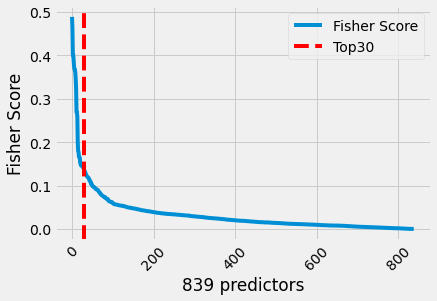

CPU times: total: 188 ms
Wall time: 187 ms


In [76]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=30, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top30'])
plt.show()

Added # top vars : 100


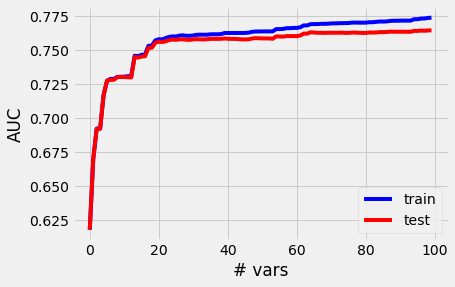

CPU times: total: 3.39 s
Wall time: 1min 12s


In [77]:
%%time
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 100
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train', 'test'])
plt.show()

In [78]:
%%time
# Select the top variables based on Fisher Score
n_top_fs_vars = 30  # Top FS vars
top_fs_vars = fs_df['predictor'].values[:n_top_fs_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 30
CPU times: total: 0 ns
Wall time: 999 µs


array(['x3_4.0', 'x4_4.0', 'x14_8', 'x5_4.0', 'x3_2.0', 'x16_7', 'x15_8',
       'x6_4.0', 'x17_7', 'x7_3.0', 'x8_3.0', 'x13_5', 'x4_2.0',
       'LIMIT_BAL', 'x5_2.0', 'x12_11', 'x6_2.0', 'x3_3.0', 'x3_5.0',
       'x41_8.0', 'x8_2.0', 'x7_2.0', 'x45_7.0', 'PAY_AMT1', 'x42_8.0',
       'x13_9', 'x44_7.0', 'x14_9', 'x30_22', 'x15_9'], dtype=object)

#### Dimensional Reduction: PCA

In [79]:
%%time
# Build PCA and check the explained variance
# Note: If the num vars were scaled (but the dummy were not) PVE is no longer correct
pca = PCA(n_components=len(predictors))
pca.fit(train[predictors])
print("PVE =", pca.explained_variance_ratio_.sum())
# Transform train, test
train_pca = pca.transform(train[predictors])

PVE = 1.0000000000000002
CPU times: total: 9.44 s
Wall time: 2.69 s


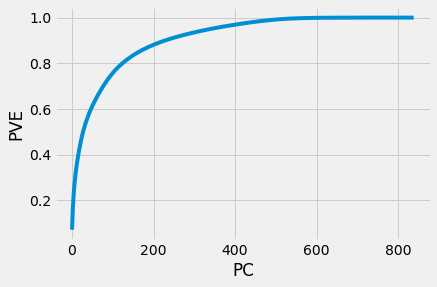

CPU times: total: 547 ms
Wall time: 192 ms


In [80]:
%%time
# Visualize the PVE of PCA
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('PC')
plt.ylabel('PVE')
plt.show()

In [81]:
%%time
# Reconstruct the loading vectors
loading_vecs = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_vecs = pd.DataFrame(loading_vecs,
                            columns=['PC' + str(i) for i in list(range(1, pca.n_components_+1))],
                            index=predictors)
loading_vecs.iloc[:2, :2]

CPU times: total: 0 ns
Wall time: 4 ms


,PC1,PC2
LIMIT_BAL,0.001173,0.002180
AGE,-0.004876,0.002733


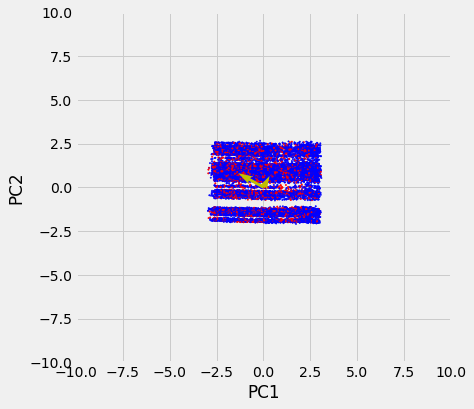

CPU times: total: 734 ms
Wall time: 721 ms


In [82]:
%%time
# Visualize the group of data
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
colors = np.array(['blue'] * len(train[target_var]))
colors[train[target_var].squeeze() == 1] = 'red'
plt.scatter(x=train_pca[:, 0], y=train_pca[:, 1], color=colors, s=2)
plt.quiver([0, 0], [0, 0],
           loading_vecs.iloc[:2, :2]['PC1'].tolist(),
           loading_vecs.iloc[:2, :2]['PC2'].tolist(),
           color=['y','y'])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [83]:
%%time
# List of parameter tuning using cross validation for all models
model_grid = {}

CPU times: total: 0 ns
Wall time: 0 ns


In [84]:
%%time
#########################################################
# MODIFY THE BELOW VALUE TO SET THE TARGET VARIABLE SET #
#########################################################
var_set = 'fs'  # all = all vars, fs = top fisher score, pca = first PCs

# Prepare the data according to the selected set of variables
var_set = 'fs'  # all = all vars, fs = top fisher score, pca = first PCs
if var_set == 'all':
    X = train[predictors]
    #X_test = test[predictors]
    #test_id = test[id_var]
elif var_set == 'fs':
    X = train[top_fs_vars]
    #X_test = test[top_fs_vars]
    #test_id = test[id_var]
elif var_set == 'pca':
    X = train_pca
    #X_test = test_pca
    #test_id = test[id_var]
y = train[target_var].values.squeeze()
print(X.shape)

# Update output file name
fname = '_' + '_' + var_set + str(X.shape[1])
print(fname)

# Remove unused data
# del train, test, train_pca, test_pca

(20000, 30)
__fs30
CPU times: total: 15.6 ms
Wall time: 5 ms


# Task 1: Select 5 machine learning predictive algorithms
Explain the mechanism of the algorithms using your own words (e.g. the general idea of the algorithm, the objective function, the algorithm fitting process, pros and cons of the algorithm, etc.)

In [85]:
# # First 
# Blind machine learning
# I define it blind because I will just throw everything I have in them and nothing more than that.
# This is a classification problem and this means that we can use the following algorithms:

# Logistic regression
# Random forest
# Support Vector Classifier
# Decision tree
# Bagging Classifier 
# Ada Boost Classifier

### 1. Logistic Regression

In [86]:
# Multiple Logistic Regression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# Hold Out Cross Validation:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [88]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
# Create the parameter grid
param_grid_lr = [{
    'logisticregression__C': [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 10.0],
}]

# Create an instance of GridSearch with 10 fold Cross-validation estimator
pipelineLR = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, penalty='l2', solver='lbfgs'))

gridLR = GridSearchCV(estimator=pipelineLR,
                     param_grid = param_grid_lr,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=-1)
# Train the LogisticRegression Classifier
gsLR = gridLR.fit(X_train, y_train)

best = gsLR.best_estimator_
classifier = best

classifier.fit(X_train, y_train)

probs_lr = classifier.predict_proba(X_test)[:, 1]
# Print the training score of the best model
print(gsLR.best_score_)

# Print the model parameters of the best model
print(gsLR.best_params_)

# Print the test score of the best model
clfLR = gsLR.best_estimator_
print('Test accuracy: %.3f' % clfLR.score(X_test, y_test))
print("AUC test: %.3f'" % roc_auc_score(y_test, probs_lr))
      

0.8174999999999999
{'logisticregression__C': 0.01}
Test accuracy: 0.817
AUC test: 0.745'
CPU times: total: 891 ms
Wall time: 3.84 s


### 2. Random Forest Classifier

In [89]:
%%time
pipelineRFC = make_pipeline(StandardScaler(), RandomForestClassifier(criterion='gini', random_state=1))

# Create the parameter grid
param_grid_rfc = [{
    'randomforestclassifier__max_depth':[2, 3, 4],
    'randomforestclassifier__max_features':[2, 3, 4, 5, 6]
}]
#
# Create an instance of GridSearch Cross-validation estimator
gsRFC = GridSearchCV(estimator=pipelineRFC,
                     param_grid = param_grid_rfc,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=-1)
# Train the RandomForestClassifier
gsRFC = gsRFC.fit(X_train, y_train)

# Print the training score of the best model
print(gsRFC.best_score_)

# Print the model parameters of the best model
print(gsRFC.best_params_)

# Print the test score of the best model

clfRFC = gsRFC.best_estimator_
print('Test accuracy: %.3f' % clfRFC.score(X_test, y_test))
best = gsRFC.best_estimator_
classifier = best

classifier.fit(X_train, y_train)

probs_rf = classifier.predict_proba(X_test)[:, 1]

print("AUC: %.3f'" % roc_auc_score(y_test, probs_rf))

0.8110625
{'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 6}
Test accuracy: 0.809
AUC: 0.742'
CPU times: total: 2.78 s
Wall time: 27.9 s


### 3. Support Vector Classifier (SVC)

In [90]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, roc_auc_score
from scipy import stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

mdl = SVC(probability = True, random_state = 1)

rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
              
rand_search = RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 20, n_jobs = -1, cv = 3, random_state = 2017, scoring = "accuracy") 
rand_search.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=SVC(probability=True, random_state=1),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023749CD48B0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000023749CA8DF0>},
                   random_state=2017, scoring='accuracy')

In [91]:
%%time

# Print the training score of the best model
print(rand_search.best_score_)

# Print the model parameters of the best model
print(rand_search.best_params_)

# Print the test score of the best model

clfSVC = rand_search.best_estimator_
print('Test accuracy: %.3f' % clfSVC.score(X_test, y_test))
best = rand_search.best_estimator_
classifier = best
classifier.fit(X_train, y_train)
probs_svc = classifier.predict_proba(X_test)[:, 1]

print("AUC: %.3f'" % roc_auc_score(y_test, probs_svc))

0.8153121938887584
{'C': 2.284060232418668, 'gamma': 0.18526529667690875}
Test accuracy: 0.815
AUC: 0.684'
CPU times: total: 1min 12s
Wall time: 1min 12s


### 4. Decission Tree

In [92]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split

In [93]:
%%time
#create the classifier
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_train, y_train)

best = grid_search_cv.best_estimator_
classifier = best

# classifier = DecisionTreeClassifier(max_depth=10, random_state=14) 
# training the classifier
classifier.fit(X_train, y_train)
# do our predictions on the test
predictions = classifier.predict(X_test)
# see how good we did on the test
print(accuracy_score(y_true = y_test, y_pred = predictions))

probs_dt = classifier.predict_proba(X_test)[:, 1]

print("AUC: %.3f'" % roc_auc_score(y_test, probs_dt))

Fitting 3 folds for each of 294 candidates, totalling 882 fits
0.814
AUC: 0.714'
CPU times: total: 24.3 s
Wall time: 24.3 s


### 5.  Bagging Classifier (Ensemble)

In [94]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [95]:
%%time
# # Pipeline Estimator
# pipeline = make_pipeline(StandardScaler(),
#                         LogisticRegression(random_state=1))
# #
# # Instantiate the bagging classifier
# #
# bgclassifier = BaggingClassifier(base_estimator=pipeline, n_estimators=100,
#                                  max_features=10,
#                                  max_samples=100,
#                                  random_state=1, n_jobs=5)

param_grid = {
    'base_estimator__max_depth' : [1, 3, 5],
    'max_samples' : [0.05, 0.2, 0.5]
}

bgclassifier = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
                                     n_estimators = 100, max_features = 0.5),
                   param_grid, scoring='accuracy', cv=3, refit=True,n_jobs=-1)
bgclassifier.fit(X_train, y_train)

# Model scores on test and training data
print('Model test Score: %.3f, ' %bgclassifier.score(X_test, y_test),
      'Model training Score: %.3f' %bgclassifier.score(X_train, y_train))

Model test Score: 0.809,  Model training Score: 0.811
CPU times: total: 844 ms
Wall time: 5.54 s


In [96]:
%%time
# Print the training score of the best model
print(bgclassifier.best_score_)

# Print the model parameters of the best model
print(bgclassifier.best_params_)

# Print the test score of the best model

clfBC = bgclassifier.best_estimator_
print('Test accuracy: %.3f' % clfSVC.score(X_test, y_test))
best = bgclassifier.best_estimator_
classifier = best
classifier.fit(X_train, y_train)
probs_bc = classifier.predict_proba(X_test)[:, 1]

print("AUC: %.3f'" % roc_auc_score(y_test, probs_bc))

0.8108748149402757
{'base_estimator__max_depth': 3, 'max_samples': 0.2}
Test accuracy: 0.815
AUC: 0.739'
CPU times: total: 3.22 s
Wall time: 3.23 s


### 6. Ada Boost Classifier (Ensemble)

In [97]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

In [101]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
#from sklearn.grid_search import GridSearchCV

param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]
             }

DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "balanced",max_depth = None)

ABC = AdaBoostClassifier(base_estimator = DTC)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'accuracy',cv = 3, n_jobs=-1 )
grid_search_ABC.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                max_features='auto',
                                                                                random_state=11)),
             n_jobs=-1,
             param_grid={'base_estimator__criterion': ['gini', 'entropy'],
                         'base_estimator__splitter': ['best', 'random'],
                         'n_estimators': [1, 2]},
             scoring='accuracy')

In [104]:
%%time
# Print the training score of the best model
print(grid_search_ABC.best_score_)

# Print the model parameters of the best model
print(grid_search_ABC.best_params_)

# Print the test score of the best model

clfBC = grid_search_ABC.best_estimator_
print('Test accuracy: %.3f' % clfSVC.score(X_test, y_test))
best = grid_search_ABC.best_estimator_
classifier = best
classifier.fit(X_train, y_train)
probs_ada = classifier.predict_proba(X_test)[:, 1]

print("AUC: %.3f'" % roc_auc_score(y_test, probs_ada))

0.7195006188636697
{'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'random', 'n_estimators': 2}
Test accuracy: 0.815
AUC: 0.614'
CPU times: total: 2.66 s
Wall time: 2.66 s


### AUC Comparison between our 6 algorithms

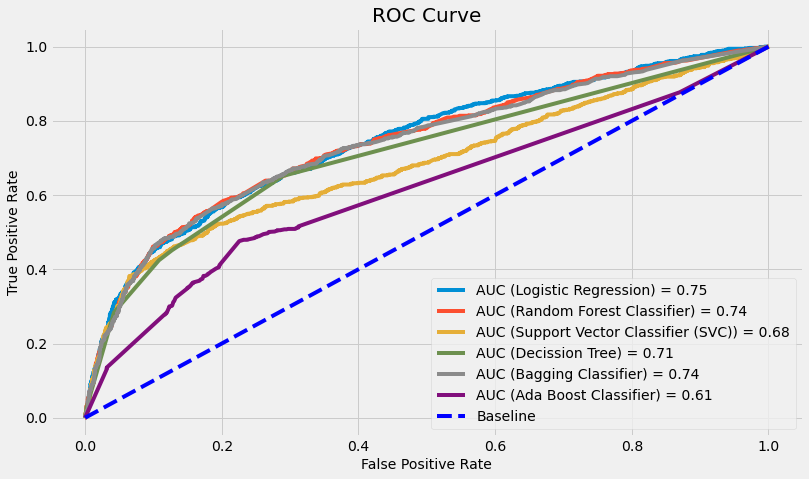

In [107]:
from sklearn.metrics import roc_auc_score, roc_curve

y_test_int = y_test
auc_lr = roc_auc_score(y_test_int, probs_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_int, probs_lr)

auc_rf = roc_auc_score(y_test_int, probs_rf)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_int, probs_rf)

auc_svc = roc_auc_score(y_test_int, probs_svc)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test_int, probs_svc)

auc_dt = roc_auc_score(y_test_int, probs_dt)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test_int, probs_dt)

auc_bc = roc_auc_score(y_test_int, probs_bc)
fpr_bc, tpr_bc, thresholds_bc = roc_curve(y_test_int, probs_bc)

auc_ada = roc_auc_score(y_test_int, probs_ada)
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test_int, probs_ada)

plt.figure(figsize=(12, 7))
plt.plot(fpr_lr, tpr_lr, label=f'AUC (Logistic Regression) = {auc_lr:.2f}')
plt.plot(fpr_rf, tpr_rf, label=f'AUC (Random Forest Classifier) = {auc_rf:.2f}')
plt.plot(fpr_svc, tpr_svc, label=f'AUC (Support Vector Classifier (SVC)) = {auc_svc:.2f}')
plt.plot(fpr_dt, tpr_dt, label=f'AUC (Decission Tree) = {auc_dt:.2f}')
plt.plot(fpr_bc, tpr_bc, label=f'AUC (Bagging Classifier) = {auc_bc:.2f}')
plt.plot(fpr_ada, tpr_ada, label=f'AUC (Ada Boost Classifier) = {auc_ada:.2f}')

plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('ROC Curve', size=20)
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend();

In [123]:
# References: 
# https://medium.com/@hertan06/which-features-to-use-in-your-model-350630a1e31c
# https://medium.com/@eijaz/holdout-vs-cross-validation-in-machine-learning-7637112d3f8f
# https://vitalflux.com/grid-search-explained-python-sklearn-examples/#Grid_Search_and_Random_Forest_Classifier
# https://towardsdatascience.com/roc-and-auc-how-to-evaluate-machine-learning-models-in-no-time-fb2304c83a7f
# https://medium.com/analytics-vidhya/decisiontree-classifier-working-on-moons-dataset-using-gridsearchcv-to-find-best-hyperparameters-ede24a06b489
# https://www.datacamp.com/community/tutorials/adaboost-classifier-python
# Mutual information. Link: https://en.wikipedia.org/wiki/Mutual_information
# sklearn.feature_selection.mutual_info_classif. Link: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html
# Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.
# Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.
# Lessmann, S., Baesens, B., Seow, H. V., & Thomas, L. C. (2015). Benchmarking state-of-the-art classification algorithms for credit scoring: An update of research. European Journal of Operational Research, 247(1), 124-136.File 
# Ensemble methods. Link: https://scikit-learn.org/stable/modules/ensemble
# Dr. Phan Minh, MBD2021_InClass Kaggle_2_Modeling_Group1_Py_v5.3 - Data Processing